<center>
<img src="https://habrastorage.org/files/fd4/502/43d/fd450243dd604b81b9713213a247aa20.jpg">
    
## [mlcourse.ai](https://mlcourse.ai) - Open Machine Learning Course
Auteur: [Yury Kashnitskiy](https://yorko.github.io) (@yorko). Edité et traduit par [Ousmane Cissé](https://github.com/oussou-dev). Ce matériel est soumis aux termes et conditions de la licence [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). L'utilisation gratuite est autorisée à des fins non commerciales.</center>

## <center> Mission 4. Détection des sarcasmes avec la régression logistique. Solution
    
Nous utiliserons le jeu de données de [paper](https://arxiv.org/abs/1704.05579) "Un grand corpus auto-annoté pour le sarcasme" avec plus de 1 million de commentaires provenant du site Reddit, étiquetés comme sarcastiques ou non. Une version complète peut être trouvée sur Kaggle sous la forme d'un [Jeu de données Kaggle](https://www.kaggle.com/danofer/sarcasm).</center>

In [1]:
PATH_TO_DATA = '../input/sarcasm/train-balanced-sarcasm.csv'

In [2]:
# some necessary imports
import os
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt

In [3]:
train_df = pd.read_csv(PATH_TO_DATA)

In [4]:
train_df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010826 entries, 0 to 1010825
Data columns (total 10 columns):
label             1010826 non-null int64
comment           1010773 non-null object
author            1010826 non-null object
subreddit         1010826 non-null object
score             1010826 non-null int64
ups               1010826 non-null int64
downs             1010826 non-null int64
date              1010826 non-null object
created_utc       1010826 non-null object
parent_comment    1010826 non-null object
dtypes: int64(4), object(6)
memory usage: 77.1+ MB


Certains commentaires sont manquants, alors nous supprimons les lignes correspondantes.

In [6]:
train_df.dropna(subset=['comment'], inplace=True)

Nous remarquons que le jeu de données est bien équilibré

In [7]:
train_df['label'].value_counts()

0    505405
1    505368
Name: label, dtype: int64

Nous divisons les données en données d'entraînement et données de validation.

In [8]:
train_texts, valid_texts, y_train, y_valid = \
        train_test_split(train_df['comment'], train_df['label'], random_state=17)

## Les tâches:
1. Analysez le jeu de données, faites des graphiques. Ce [kernel](https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-qiqc) pourrait servir d'exemple.
2. Créez un Tf-Idf + un pipeline de régression logistique pour prédire le sarcasme (`label`) en fonction du texte d'un commentaire sur Reddit (` comment`).
3. Tracer les mots/bigrammes qui sont les plus prédictifs du sarcasme (vous pouvez utiliser [eli5](https://github.com/TeamHG-Memex/eli5) pour cela)
4. (facultatif) ajouter des sous-titres (subreddits) en tant que nouvelles caractéristiques pour améliorer les performances du modèle. Appliquez ici l’approche Sac de mots (Bag of Words), c’est-à-dire traitez chaque sous-titre comme une nouvelle caractéristique.

### Partie 1. Analyse exploratoire des données

La distribution des longueurs pour les commentaires sarcastiques et normaux est presque la même.

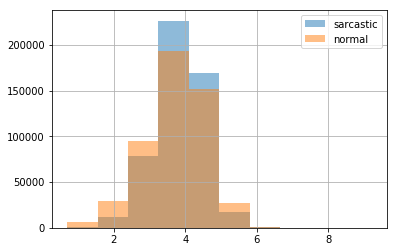

In [9]:
train_df.loc[train_df['label'] == 1, 'comment'].str.len().apply(np.log1p).hist(label='sarcastic', alpha=.5)
train_df.loc[train_df['label'] == 0, 'comment'].str.len().apply(np.log1p).hist(label='normal', alpha=.5)
plt.legend();

In [10]:
from wordcloud import WordCloud, STOPWORDS

In [11]:
wordcloud = WordCloud(background_color='black', stopwords = STOPWORDS,
                max_words = 200, max_font_size = 100, 
                random_state = 17, width=800, height=400)

Le nuage de mots est beau, mais pas très utile

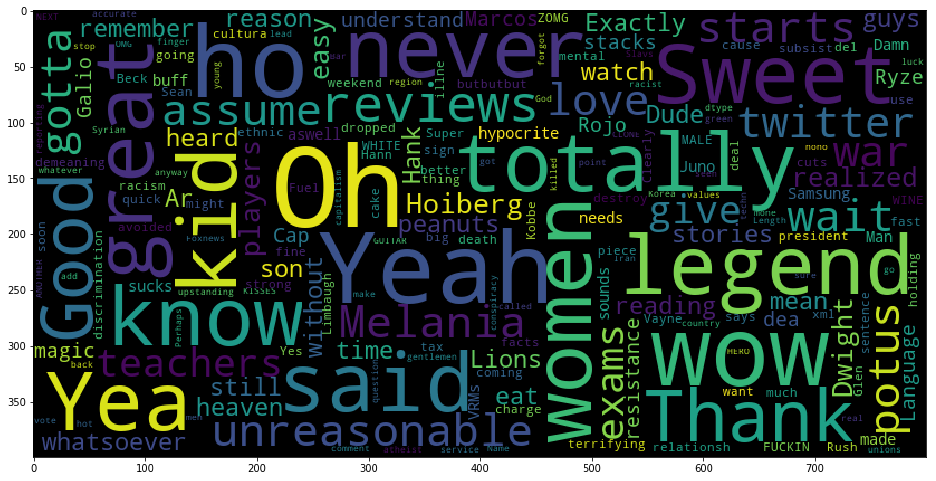

In [12]:
plt.figure(figsize=(16, 12))
wordcloud.generate(str(train_df.loc[train_df['label'] == 1, 'comment']))
plt.imshow(wordcloud);

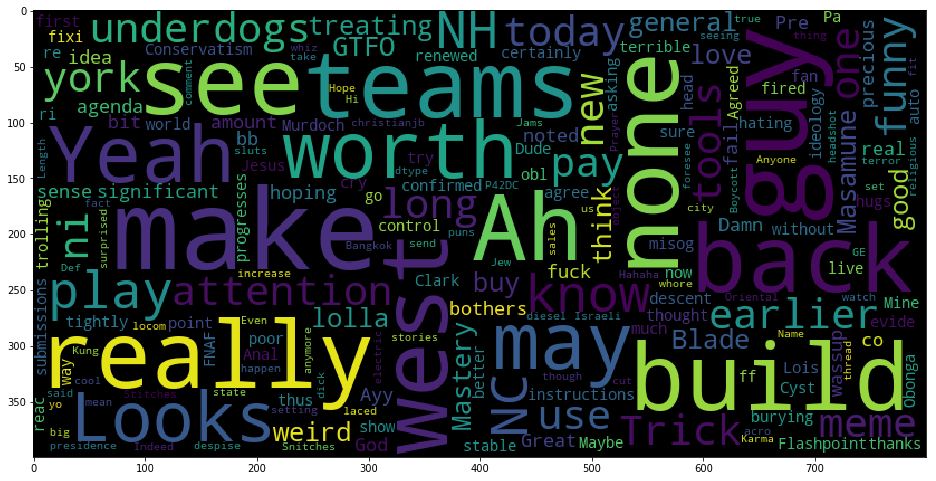

In [13]:
plt.figure(figsize=(16, 12))
wordcloud.generate(str(train_df.loc[train_df['label'] == 0, 'comment']))
plt.imshow(wordcloud);

Analysons si certains sous-titres (subreddits) sont plus "sarcastiques" en moyenne que d'autres

In [14]:
sub_df = train_df.groupby('subreddit')['label'].agg([np.size, np.mean, np.sum])
sub_df.sort_values(by='sum', ascending=False).head(10)

,size,mean,sum
subreddit,,,
AskReddit,65674,0.401453,26365
politics,39493,0.605348,23907
worldnews,26376,0.642516,16947
leagueoflegends,21034,0.542312,11407
pcmasterrace,18987,0.566651,10759
news,16891,0.603457,10193
funny,17939,0.451474,8099
pics,16152,0.484336,7823
todayilearned,14159,0.547567,7753


In [15]:
sub_df[sub_df['size'] > 1000].sort_values(by='mean', ascending=False).head(10)

,size,mean,sum
subreddit,,,
creepyPMs,5466,0.784303,4287
MensRights,3355,0.680775,2284
ShitRedditSays,1284,0.661994,850
worldnews,26376,0.642516,16947
Libertarian,2562,0.640125,1640
atheism,7377,0.639555,4718
Conservative,1881,0.639553,1203
TwoXChromosomes,1560,0.632692,987
fatlogic,2356,0.623090,1468


La même chose pour les auteurs ne donne pas beaucoup de perspicacité. Hormis le fait que les commentaires de quelqu'un aient été échantillonnés, nous pouvons constater le même nombre de commentaires sarcastiques et non sarcastiques.

In [16]:
sub_df = train_df.groupby('author')['label'].agg([np.size, np.mean, np.sum])
sub_df[sub_df['size'] > 300].sort_values(by='mean', ascending=False).head(10)

,size,mean,sum
author,,,
NeonDisease,422,0.500000,211
ShyBiDude89,404,0.500000,202
ivsciguy,342,0.500000,171
mad-n-fla,318,0.500000,159
mindlessrabble,302,0.500000,151
pokemon_fetish,432,0.500000,216
Biffingston,845,0.499408,422


In [17]:
sub_df = train_df[train_df['score'] >= 0].groupby('score')['label'].agg([np.size, np.mean, np.sum])
sub_df[sub_df['size'] > 300].sort_values(by='mean', ascending=False).head(10)

,size,mean,sum
score,,,
0,58141,0.612752,35626
20,3096,0.561370,1738
34,1071,0.556489,596
26,1874,0.554429,1039
59,315,0.552381,174
18,3951,0.551759,2180
13,7277,0.546929,3980
17,4404,0.545867,2404
40,722,0.545706,394


In [18]:
sub_df = train_df[train_df['score'] < 0].groupby('score')['label'].agg([np.size, np.mean, np.sum])
sub_df[sub_df['size'] > 300].sort_values(by='mean', ascending=False).head(10)

,size,mean,sum
score,,,
-14,537,0.698324,375
-8,1852,0.696004,1289
-9,1503,0.691284,1039
-6,3088,0.688795,2127
-12,776,0.684278,531
-5,4134,0.678520,2805
-3,6736,0.676069,4554
-2,11924,0.675948,8060
-4,5436,0.673473,3661


### Partie 2. Entraîner le modèle

In [19]:
# build bigrams, put a limit on maximal number of features
# and minimal word frequency
tf_idf = TfidfVectorizer(ngram_range=(1, 2), max_features=50000, min_df=2)
# multinomial logistic regression a.k.a softmax classifier
logit = LogisticRegression(C=1, n_jobs=4, solver='lbfgs', 
                           random_state=17, verbose=1)
# sklearn's pipeline
tfidf_logit_pipeline = Pipeline([('tf_idf', tf_idf), 
                                 ('logit', logit)])

In [20]:
%%time
tfidf_logit_pipeline.fit(train_texts, y_train)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


CPU times: user 39.6 s, sys: 2.73 s, total: 42.3 s
Wall time: 1min 7s


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   26.1s finished


Pipeline(memory=None,
     steps=[('tf_idf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=50000, min_df=2,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=Tru... penalty='l2', random_state=17, solver='lbfgs', tol=0.0001,
          verbose=1, warm_start=False))])

In [21]:
%%time
valid_pred = tfidf_logit_pipeline.predict(valid_texts)

CPU times: user 6.53 s, sys: 80 ms, total: 6.61 s
Wall time: 6.6 s


In [22]:
accuracy_score(y_valid, valid_pred)

0.7208560551497067

### Partie 3. Expliquer le modèle

In [23]:
def plot_confusion_matrix(actual, predicted, classes,
                          normalize=False,
                          title='Confusion matrix', figsize=(7,7),
                          cmap=plt.cm.Blues, path_to_save_fig=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(actual, predicted).T
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Predicted label')
    plt.xlabel('True label')
    
    if path_to_save_fig:
        plt.savefig(path_to_save_fig, dpi=300, bbox_inches='tight')

La matrice de confusion est assez équilibrée.

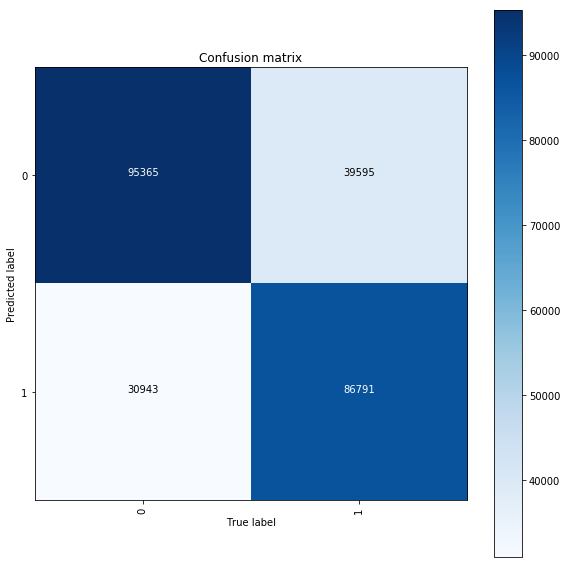

In [24]:
plot_confusion_matrix(y_valid, valid_pred, 
                      tfidf_logit_pipeline.named_steps['logit'].classes_, figsize=(8, 8))

En effet, nous pouvons reconnaître certaines expressions indiquant un sarcasme. Comme "oui bien sûr".

In [25]:
import eli5
eli5.show_weights(estimator=tfidf_logit_pipeline.named_steps['logit'],
                  vec=tfidf_logit_pipeline.named_steps['tf_idf'])

Weight?,Feature
+9.328,yes because
+7.904,clearly
+7.374,obviously
+7.268,yeah because
+6.880,totally
+6.192,because
+6.080,how dare
+5.935,right because
+5.405,but thought
+5.234,duh


So sarcasm detection is easy.
<img src="https://habrastorage.org/webt/1f/0d/ta/1f0dtavsd14ncf17gbsy1cvoga4.jpeg">

### Partie 4. Améliorer le modèle

In [26]:
subreddits = train_df['subreddit']
train_subreddits, valid_subreddits = train_test_split(subreddits, random_state=17)

Nous aurons des vectoriseurs Tf-Idf séparés pour les commentaires et les sous-titres (subreddits). Il est également possible de s'en tenir à un pipeline, mais dans ce cas, cela devient un peu moins simple. [Exemple](https://stackoverflow.com/questions/36731813/computing-separate-tfidf-scores-for-two-dwifferent-columns-using-sklearn)

In [27]:
tf_idf_texts = TfidfVectorizer(ngram_range=(1, 2), max_features=50000, min_df=2)
tf_idf_subreddits = TfidfVectorizer(ngram_range=(1, 1))

Faites des transformations séparément pour les commentaires et les sous-titres.

In [28]:
%%time
X_train_texts = tf_idf_texts.fit_transform(train_texts)
X_valid_texts = tf_idf_texts.transform(valid_texts)

CPU times: user 45.7 s, sys: 2.12 s, total: 47.8 s
Wall time: 47.8 s


In [29]:
X_train_texts.shape, X_valid_texts.shape

((758079, 50000), (252694, 50000))

In [30]:
%%time
X_train_subreddits = tf_idf_subreddits.fit_transform(train_subreddits)
X_valid_subreddits = tf_idf_subreddits.transform(valid_subreddits)

CPU times: user 3.48 s, sys: 0 ns, total: 3.48 s
Wall time: 3.48 s


In [31]:
X_train_subreddits.shape, X_valid_subreddits.shape

((758079, 13255), (252694, 13255))

Ensuite, empilez toutes les caractéristiques ensemble.

In [32]:
from scipy.sparse import hstack
X_train = hstack([X_train_texts, X_train_subreddits])
X_valid = hstack([X_valid_texts, X_valid_subreddits])

In [33]:
X_train.shape, X_valid.shape

((758079, 63255), (252694, 63255))

Entraînez de même la régression logistique.

In [34]:
logit.fit(X_train, y_train)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   22.8s finished


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=4,
          penalty='l2', random_state=17, solver='lbfgs', tol=0.0001,
          verbose=1, warm_start=False)

In [35]:
%%time
valid_pred = logit.predict(X_valid)

CPU times: user 168 ms, sys: 0 ns, total: 168 ms
Wall time: 167 ms


In [36]:
accuracy_score(y_valid, valid_pred)

0.7237647114692078

Comme on peut le constater, la précision a légèrement augmenté.

## Liens:
  - Machine learning library [Scikit-learn](https://scikit-learn.org/stable/index.html) (a.k.a. sklearn)
  - Kernels on [logistic regression](https://www.kaggle.com/kashnitsky/topic-4-linear-models-part-2-classification) and its applications to [text classification](https://www.kaggle.com/kashnitsky/topic-4-linear-models-part-4-more-of-logit), also a [Kernel](https://www.kaggle.com/kashnitsky/topic-6-feature-engineering-and-feature-selection) on feature engineering and feature selection
  - [Kaggle Kernel](https://www.kaggle.com/abhishek/approaching-almost-any-nlp-problem-on-kaggle) "Approaching (Almost) Any NLP Problem on Kaggle"
  - [ELI5](https://github.com/TeamHG-Memex/eli5) to explain model predictions